# Targets at the Team and Player Level

Explain what this section is about . . . 

## Setting up the Datasets

In [165]:
library(ggplot2)
require(RPostgreSQL)
library(dplyr)
library(reshape2)

In [166]:
source('.rconfig')
drv <- dbDriver('PostgreSQL')
con <- dbConnect(drv, dbname = nfldb.database, user=nfldb.username, password=nfldb.password)

### Dataset No. 1: Team Passing

In [167]:
dataset.team.targets <- function(con, seas=2009) {
  q = paste0("SELECT season_year, team, pass_cmp, pass_att, pass_yds, pass_int, pass_td,
  row_number() OVER (PARTITION BY season_year ORDER BY pass_att DESC) as pass_att_rank
  FROM teamstats_offense_yearly
  WHERE season_year >= ", seas, 
  "ORDER BY season_year, pass_att DESC")
  dbGetQuery(con, q)
}

In [178]:
team.passing = dataset.team.targets(con)
team.passing$season_year = as.factor(team.passing$season_year)
team.passing$pass_grp = ifelse(team.passing$pass_att_rank <=8, 1, ifelse(team.passing$pass_att_rank <=16, 2, ifelse(team.passing$pass_att_rank <= 24, 3, 4)))
team.passing$pass_grp = as.factor(team.passing$pass_grp)
str(team.passing)

'data.frame':	256 obs. of  9 variables:
 $ season_year  : Factor w/ 8 levels "2009","2010",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ team         : chr  "SEA" "IND" "ARI" "HOU" ...
 $ pass_cmp     : int  372 402 392 399 390 316 332 340 341 357 ...
 $ pass_att     : int  609 601 594 593 592 585 570 563 558 553 ...
 $ pass_yds     : int  3503 4515 4016 4654 4436 3168 3571 3473 3627 4180 ...
 $ pass_int     : int  19 19 18 17 13 32 17 27 13 8 ...
 $ pass_td      : int  20 34 27 29 28 16 26 27 21 30 ...
 $ pass_att_rank: num  1 2 3 4 5 6 7 8 9 10 ...
 $ pass_grp     : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 2 2 ...


### Dataset No. 2: Player Targets

In [169]:
dataset.player.targets <- function(con, pos, seas=2009) {
  q = paste0("WITH tar AS (
    SELECT 
      season_year as seas, full_name as name, team, count(full_name) as gp,
      round(avg(receiving_tar),1) as targ_pg, 
      min(receiving_tar) AS targ_min, 
      max(receiving_tar) AS targ_max, 
      sum(receiving_tar) AS targets,
      percentile_disc(.25) WITHIN GROUP (ORDER BY receiving_tar) AS targ_p25,
      percentile_disc(.75) WITHIN GROUP (ORDER BY receiving_tar) AS targ_p75,
      sum(fpts_dk) AS fpts_tot,
      round(avg(fpts_dk),1) as fpts_pg 
    FROM weekly_stats 
    WHERE position = '", pos, "' AND season_year >= ", seas, 
  " 
    GROUP BY full_name, team, seas 
  )
  SELECT *, targ_p75 - targ_p25 as targ_iqr 
  FROM tar
  WHERE targets >= 50
  ORDER BY seas, targ_pg DESC")
  
  dbGetQuery(con, q)
}

You can add ranks using SQL window functions, as shown above, or in R, by using the rank function.

In [184]:
d = dataset.player.targets(con, pos='WR')
d = transform(d, fpts_tot_rk = ave(fpts_tot, seas, FUN = function(x) rank(-x, ties.method = "first")),
             fpts_pg_rk = ave(fpts_pg, seas, FUN = function(x) rank(-x, ties.method = "first")),
             targ_pg_rk = ave(targ_pg, seas, FUN = function(x) rank(-x, ties.method = "first")),
             targ_rk = ave(targets, seas, FUN = function(x) rank(-x, ties.method = "first")),
             targ_iqr_rk = ave(targ_iqr, seas, FUN = function(x) rank(x, ties.method = "first")))
d$targ_grp = ifelse(d$targ_pg_rk <= 12, 1, ifelse(d$targ_pg_rk <= 24, 2, ifelse(d$targ_pg_rk <= 36, 3, 4)))
d$targ_grp = as.factor(d$targ_grp)
d$seas = as.factor(d$seas)
str(d)

'data.frame':	697 obs. of  19 variables:
 $ seas       : Factor w/ 8 levels "2009","2010",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ name       : chr  "Wes Welker" "Andre Johnson" "Brandon Marshall" "Roddy White" ...
 $ team       : chr  "NE" "HOU" "DEN" "ATL" ...
 $ gp         : num  14 16 15 16 16 14 16 16 16 16 ...
 $ targ_pg    : num  11.6 10.7 10.3 10.3 9.8 9.7 9.6 9.3 8.6 8.6 ...
 $ targ_min   : num  2 4 6 5 4 1 5 6 3 4 ...
 $ targ_max   : num  17 17 28 20 16 13 15 20 14 16 ...
 $ targets    : num  162 171 154 165 157 136 154 149 137 138 ...
 $ targ_p25   : num  10 7 7 6 7 7 6 7 6 5 ...
 $ targ_p75   : num  14 14 11 12 12 12 12 10 11 11 ...
 $ fpts_tot   : num  303 333 286 278 280 ...
 $ fpts_pg    : num  21.7 20.8 19.1 17.4 17.5 15 18.3 18.8 16.4 19 ...
 $ targ_iqr   : num  4 7 4 6 5 5 6 3 5 6 ...
 $ fpts_tot_rk: num  2 1 7 10 8 22 6 4 12 3 ...
 $ fpts_pg_rk : num  1 2 3 10 9 16 8 5 13 4 ...
 $ targ_pg_rk : num  1 2 3 4 5 6 7 8 9 10 ...
 $ targ_rk    : num  3 1 5 2 4 11 6 7 10 8 ...
 $ targ

## Visualizing Team Targets

In [171]:
gb = group_by(team.passing, season_year)
d2 = summarize(gb, avg_att = mean(pass_att), 
               med_att = median(pass_att), p25_att = quantile(pass_att, .25), 
               p75_att = quantile(pass_att, .75))
d2

season_year,avg_att,med_att,p25_att,p75_att
2009,532.2812,542.5,516.75,559.25
2010,539.6562,540.0,491.00,576.25
2011,544.0625,548.0,509.75,582.50
2012,555.8750,557.5,501.25,609.75
2013,566.7500,576.5,521.25,613.00
2014,558.7188,555.5,510.50,607.50
2015,571.8125,589.0,525.25,619.50
2016,571.7188,574.0,549.00,596.50


### Histogram

The histogram is a graphical representation of the distribution of numerical data. Here, we can see that the highest concentration of team targets falls in the range of the mid-500s. 

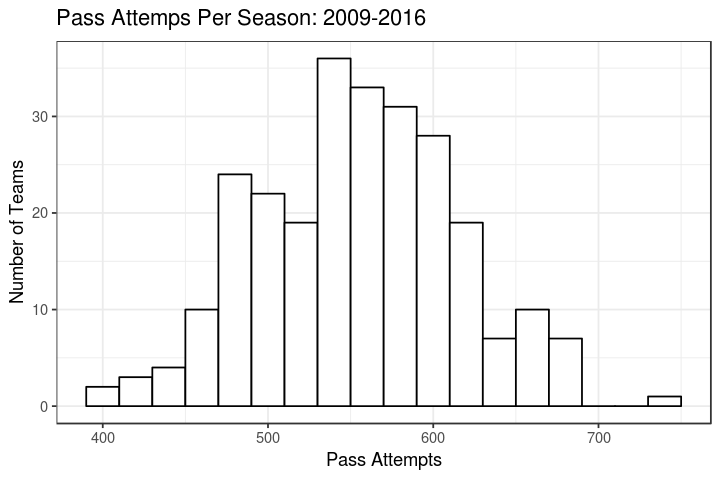

In [176]:
ggplot(team.passing, aes(x=pass_att)) + 
geom_histogram(binwidth=20,colour="black", fill="white") +
theme_bw() + labs(title="Pass Attemps Per Season: 2009-2016", y = "Number of Teams", x="Pass Attempts")

### Violin Plot

The violin plot below shows the concentration of team passing attempts from 2009-2016. The lines within each plot represent the 25th, 50th, and 75th percentiles. The width and height of the plot shows how far apart values are from each other. For example, in 2016, which has a shorter and wider plot, a large number of teams had between 550-600 pass attempts, whereas team totals were more spread out in the several years prior.

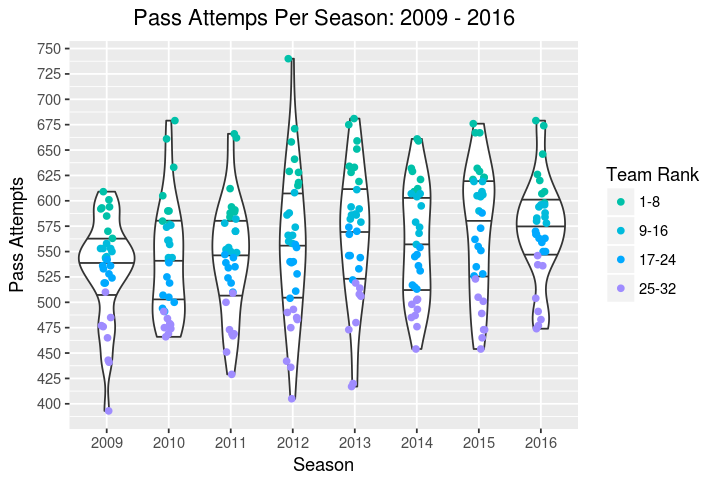

In [175]:
vp = ggplot(team.passing, aes(season_year, pass_att)) + 
geom_violin(draw_quantiles = c(0.25, 0.5, 0.75)) +  
geom_jitter(aes(color=pass_grp), height=0, width=0.1) +
labs(title = "Pass Attemps Per Season: 2009 - 2016", y = "Pass Attempts", x="Season") + 
scale_y_continuous(breaks=seq(400,750,25)) + 
theme(plot.title = element_text(hjust = 0.5))

vp + scale_colour_discrete(name="Team Rank", h = c(180, 270),
                         breaks=c("1", "2", "3", "4"),
                         labels=c("1-8", "9-16", "17-24", "25-32"))

## Visualizing WR Targets

### Histogram

The histogram is a graphical representation of the distribution of numerical data. Here, we can see that a majority of players in our dataset average between 5-9 targets per game. 

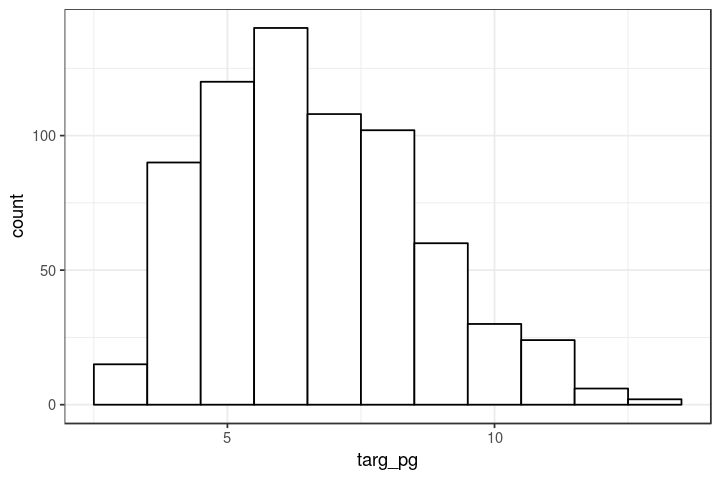

In [179]:
ggplot(d, aes(x=targ_pg)) + 
geom_histogram(binwidth=1,colour="black", fill="white") +    
theme_bw()

### Histogram with Density Curve

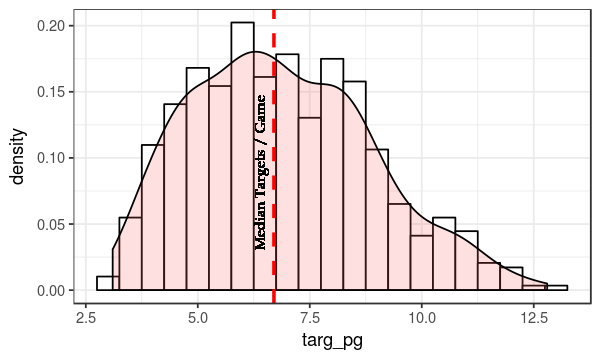

In [109]:
ggplot(d, aes(x=targ_pg)) + 
geom_histogram(aes(y=..density..), binwidth=.5,colour="black", fill="white") +    
geom_density(alpha=.2, fill="#FF6666") + 
geom_vline(aes(xintercept=median(targ_pg, na.rm=T)), color="red", linetype="dashed", size=1) + 
geom_text(x=6.5, y=.03, label="Median Targets / Game", angle=90, size=3, hjust=0, vjust=0, 
          family='Palatino', fontface='plain') + 
theme_bw()

I'll break this down into pieces so you understand (1) what the plot means and (2) how to recreate it.

### Cumulative Density Function

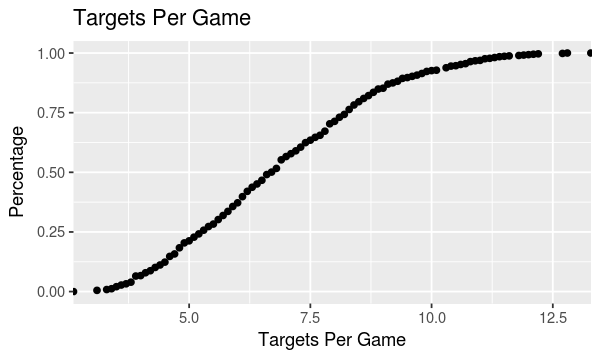

In [111]:
ggplot(d, aes(targ_pg)) + stat_ecdf(geom = "point") +
labs(title="Targets Per Game", y = "Percentage", x="Targets Per Game")

This graph shows that 25% of the players average about 5 targets per game, 50% of players average about 7 targets or less, 75% average about 8.5 targets or less, and the top 25% average between 8.5 and 13 targets.

### Violin Plot

The violin plot below shows the concentration of targets from 2009-2016. The lines within each plot represent the 25th, 50th, and 75th percentiles. The width and height of the plot shows how far apart values are from each other. For example, in 2016, which has a shorter and wider plot, a large number of teams had between 550-600 pass attempts, whereas team totals were more spread out in the several years prior.

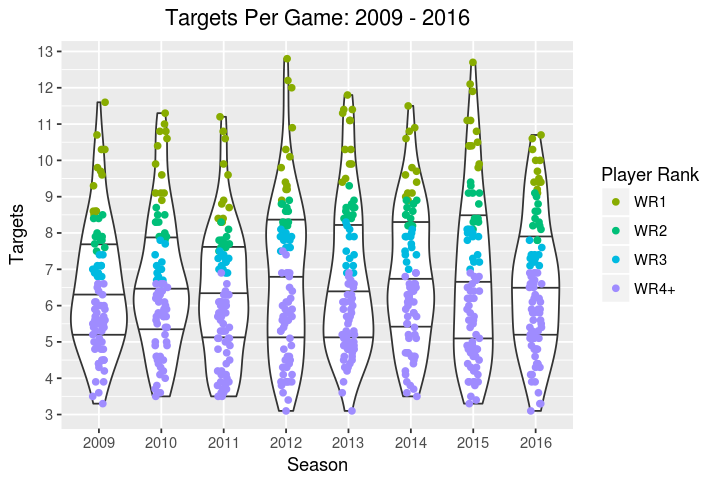

In [188]:
vp = ggplot(d, aes(seas, targ_pg)) + 
geom_violin(draw_quantiles = c(0.25, 0.5, 0.75)) +  
geom_jitter(aes(color=targ_grp), height=0, width=0.1) +
labs(title = "Targets Per Game: 2009 - 2016", y = "Targets", x="Season") + 
scale_y_continuous(breaks=seq(0,15,1)) + 
theme(plot.title = element_text(hjust = 0.5))

vp + scale_colour_discrete(name="Player Rank", h = c(100, 270),
                         breaks=c("1", "2", "3", "4"),
                         labels=c("WR1", "WR2", "WR3", "WR4+"))

In [189]:
## stopped here
## not sure what I still want to show

### Target Stats by Year

In [115]:
gb = group_by(d, season_year)
d2 = summarize(gb, avg_targ_g = mean(targ_pg), avg_targ_25 = mean(targ_p25), avg_targ_75 = mean(targ_p75))
d2$season_year = as.factor(d2$season_year)

In [15]:
d2$p25 = d2$avg_targ_25
d2$avg = d2$avg_targ_g - d2$avg_targ_25
d2$p75 = d2$avg_targ_75 - d2$avg_targ_g

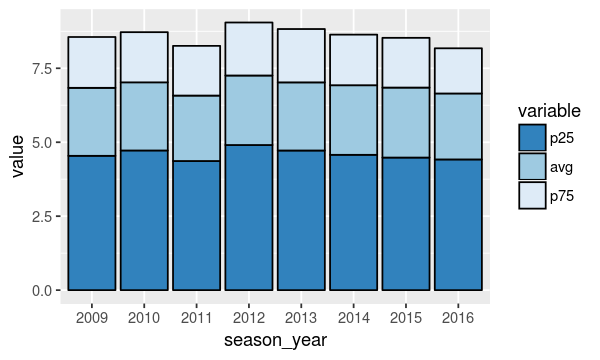

In [37]:

d3 = melt(subset(d2, select=c(season_year, p25, avg, p75)), id=c("season_year"))
d3$variable = factor(d3$variable, levels=c("p75", "avg", "p25"))
ggplot(d3, aes(y=value, x=season_year, fill=variable)) + 
geom_bar(stat='identity', color='black') + 
guides(fill=guide_legend(reverse=T)) +
scale_fill_brewer()

## Correlation Matrix

In [95]:
cor(subset(d, select=-c(season_year, full_name, team, gp)))

,targ_pg,targ_min,targ_max,targets,targ_p25,targ_p75,fpts_tot,fpts_pg
targ_pg,1.0000000,0.7517344,0.8157421,0.8955754,0.9140462,0.9391119,0.7991838,0.8707717
targ_min,0.7517344,1.0000000,0.5547556,0.6637071,0.7342801,0.6434473,0.6166431,0.6805622
targ_max,0.8157421,0.5547556,1.0000000,0.7681001,0.6515353,0.7469875,0.6863254,0.7138136
targets,0.8955754,0.6637071,0.7681001,1.0000000,0.8116342,0.8148068,0.8933932,0.7899444
targ_p25,0.9140462,0.7342801,0.6515353,0.8116342,1.0000000,0.8015084,0.7257098,0.7973004
targ_p75,0.9391119,0.6434473,0.7469875,0.8148068,0.8015084,1.0000000,0.7152594,0.8042130
fpts_tot,0.7991838,0.6166431,0.6863254,0.8933932,0.7257098,0.7152594,1.0000000,0.9237972
fpts_pg,0.8707717,0.6805622,0.7138136,0.7899444,0.7973004,0.8042130,0.9237972,1.0000000


## Utility Functions

In [59]:
# helper function to plot multiple graphs on same plot
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
    library(grid)
    
    # Make a list from the ... arguments and plotlist
    plots <- c(list(...), plotlist)
    
    numPlots = length(plots)
    
    # If layout is NULL, then use 'cols' to determine layout
    if (is.null(layout)) {
        # Make the panel
        # ncol: Number of columns of plots
        # nrow: Number of rows needed, calculated from # of cols
        layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                     ncol = cols, nrow = ceiling(numPlots/cols))
    }
    
    if (numPlots==1) {
        print(plots[[1]])
        
    } else {
        # Set up the page
        grid.newpage()
        pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))
        
        # Make each plot, in the correct location
        for (i in 1:numPlots) {
           # Get the i,j matrix positions of the regions that contain this subplot
           matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))
           
           print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                    layout.pos.col = matchidx$col))
        }
    }
}

In [116]:
options(repr.plot.width=5, repr.plot.height=3)